In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
sentiment_path = '/content/drive/MyDrive/ds_aryan_jade/csv_files/fear_greed_index.csv'
trades_path = '/content/drive/MyDrive/ds_aryan_jade/csv_files/historical_data.csv'

sentiment = pd.read_csv(sentiment_path)
trades = pd.read_csv(trades_path)


In [11]:
print(type(sentiment))
print(type(trades))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [13]:
print(sentiment.head())
print(trades.head())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50 

In [16]:
print(trades.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [41]:
trades.columns = trades.columns.str.strip()





In [42]:
trades.rename(columns={
      "Execution Price": "execution_price",
      "Size Tokens": "size_tokens",
      "Size USD": "size_usd",
      "Closed PnL": "closed_pnl"
}, inplace=True)


In [43]:
trades["time"] = pd.to_datetime(
  trades["Timestamp IST"],
  format="%d-%m-%Y %H:%M",
  errors="coerce"
)


In [44]:
trades["date"] = trades["time"].dt.date


In [45]:
print(trades["date"].min(), trades["date"].max())


2023-05-01 2025-05-01


In [46]:
num_cols = ["execution_price", "size_tokens", "size_usd", "closed_pnl"]
for col in num_cols:
    trades[col] = pd.to_numeric(trades[col], errors="coerce")


In [47]:
trades["closed_pnl"] = trades["closed_pnl"].fillna(0)
trades = trades.dropna(subset=["execution_price", "size_usd"])


In [48]:
daily_metrics = trades.groupby("date").agg(
  total_trades=("Trade ID", "count"),
  total_volume_usd=("size_usd", "sum"),
  avg_trade_size_usd=("size_usd", "mean"),
  net_pnl=("closed_pnl", "sum"),
  profitable_trades=("closed_pnl", lambda x: (x > 0).sum())
).reset_index()


In [49]:
daily_metrics["win_rate"] = (
      daily_metrics["profitable_trades"] / daily_metrics["total_trades"]
      )


In [50]:
daily_metrics.head()
print(daily_metrics["date"].min(), daily_metrics["date"].max())


2023-05-01 2025-05-01


In [61]:
# STEP 7: Clean & Prepare Sentiment Data (FINAL)

sentiment.columns = sentiment.columns.str.strip()

# Normalize date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

# Normalize sentiment labels
sentiment["classification"] = (
    sentiment["classification"]
    .str.lower()
    .str.strip()
            )

sentiment["classification"] = sentiment["classification"].replace({
  "extreme greed": "greed",
  "extreme fear": "fear",
  "neutral": "fear"
})

sentiment["classification"] = sentiment["classification"].str.capitalize()

# Binary sentiment
sentiment["sentiment_binary"] = sentiment["classification"].map({
  "Fear": 0,
  "Greed": 1
})


In [62]:
merged_df = pd.merge(
      daily_metrics,
      sentiment[["date", "classification", "sentiment_binary"]],
      on="date",
      how="inner"
)


In [63]:
merged_df["sentiment_binary"].isna().sum()
merged_df["classification"].value_counts()


,count
classification,
Greed,307
Fear,172


In [64]:
print("Merged rows:", len(merged_df))
merged_df["sentiment_binary"].isna().sum()


Merged rows: 479


np.int64(0)

In [65]:
final_table = merged_df.groupby("classification").mean(numeric_only=True)
final_table


,total_trades,total_volume_usd,avg_trade_size_usd,net_pnl,profitable_trades,win_rate,sentiment_binary
classification,,,,,,,
Fear,703.040698,4.523553e+06,6572.967544,31332.478870,284.366279,0.330049,0.0
Greed,294.120521,1.345432e+06,5872.025677,15847.884637,123.622150,0.384793,1.0


In [66]:
daily_metrics.to_csv("daily_metrics.csv", index=False)
merged_df.to_csv("merged_trading_sentiment.csv", index=False)


<Figure size 600x400 with 0 Axes>

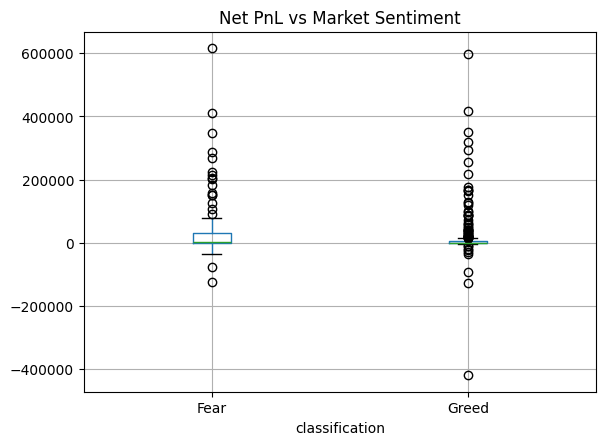

In [67]:
plt.figure(figsize=(6,4))
merged_df.boxplot(column="net_pnl", by="classification")
plt.title("Net PnL vs Market Sentiment")
plt.suptitle("")
plt.savefig("pnl_vs_sentiment.png")
plt.show()


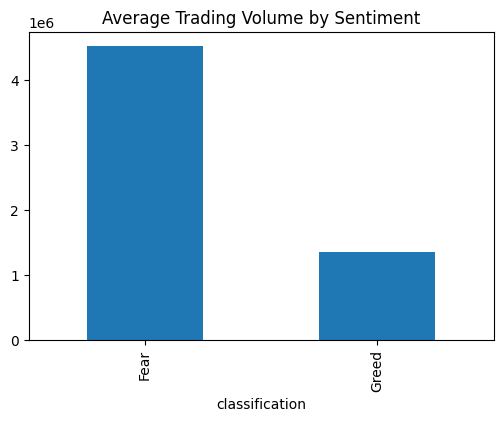

In [68]:
plt.figure(figsize=(6,4))
merged_df.groupby("classification")["total_volume_usd"].mean().plot(kind="bar")
plt.title("Average Trading Volume by Sentiment")
plt.savefig("volume_by_sentiment.png")
plt.show()


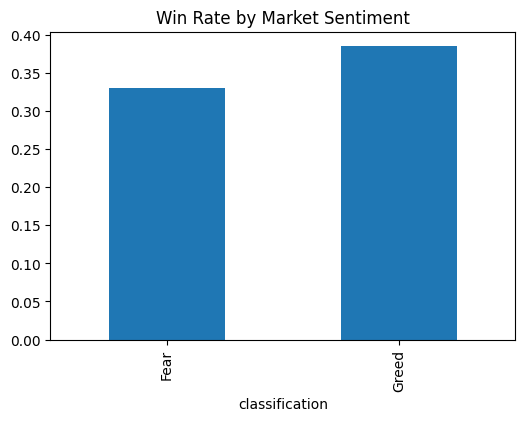

In [69]:
plt.figure(figsize=(6,4))
merged_df.groupby("classification")["win_rate"].mean().plot(kind="bar")
plt.title("Win Rate by Market Sentiment")
plt.savefig("winrate_by_sentiment.png")
plt.show()
